## Air Quality Forecasting

In [1]:
#installing all libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Layer, Input, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.layers import Attention, MultiHeadAttention, LayerNormalization, Add, Multiply
from sklearn.metrics import mean_squared_error

## Load Data

In [2]:
data =  pd.read_csv('archive/station_hour.csv')

In [3]:
data.head()

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24 17:00:00,60.50,98.00,2.35,30.80,18.25,8.50,0.1,11.85,126.40,0.1,6.10,0.10,NaN,NaN
1,AP001,2017-11-24 18:00:00,65.50,111.25,2.70,24.20,15.07,9.77,0.1,13.17,117.12,0.1,6.25,0.15,NaN,NaN
2,AP001,2017-11-24 19:00:00,80.00,132.00,2.10,25.18,15.15,12.02,0.1,12.08,98.98,0.2,5.98,0.18,NaN,NaN
3,AP001,2017-11-24 20:00:00,81.50,133.25,1.95,16.25,10.23,11.58,0.1,10.47,112.20,0.2,6.72,0.10,NaN,NaN
4,AP001,2017-11-24 21:00:00,75.25,116.00,1.43,17.48,10.43,12.03,0.1,9.12,106.35,0.2,5.75,0.08,NaN,NaN


# EDA

In [4]:
data.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,1.941394e+06,1.469831e+06,2.035372e+06,2.060110e+06,2.098275e+06,1.352465e+06,2.089781e+06,1.846346e+06,1.863110e+06,1.727504e+06,1.546717e+06,513979.000000,2.018893e+06
mean,8.086481e+01,1.584839e+02,2.278825e+01,3.523689e+01,4.055115e+01,2.870856e+01,1.502366e+00,1.211602e+01,3.806408e+01,3.305493e+00,1.490266e+01,2.448881,1.801730e+02
std,8.947618e+01,1.397883e+02,4.846146e+01,3.497508e+01,5.590894e+01,2.753244e+01,6.292445e+00,1.467385e+01,4.710653e+01,1.214053e+01,3.329729e+01,8.973470,1.404095e+02
min,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,0.000000e+00,1.000000e-02,0.000000e+00,1.000000e-02,1.000000e-02,0.000000e+00,0.000000e+00,0.000000,5.000000e+00
25%,2.816000e+01,6.400000e+01,3.050000e+00,1.310000e+01,1.135000e+01,1.123000e+01,4.100000e-01,4.250000e+00,1.102000e+01,8.000000e-02,3.400000e-01,0.000000,8.400000e+01
50%,5.259000e+01,1.162500e+02,7.150000e+00,2.479000e+01,2.286000e+01,2.235000e+01,8.000000e-01,8.250000e+00,2.475000e+01,9.600000e-01,3.400000e+00,0.200000,1.310000e+02
75%,9.774000e+01,2.040000e+02,1.858000e+01,4.548000e+01,4.570000e+01,3.778000e+01,1.380000e+00,1.453000e+01,4.953000e+01,3.230000e+00,1.510000e+01,1.830000,2.590000e+02
max,1.000000e+03,1.000000e+03,5.000000e+02,4.999900e+02,5.000000e+02,4.999700e+02,4.985700e+02,1.999600e+02,9.970000e+02,4.980700e+02,4.999900e+02,499.990000,3.133000e+03


In [5]:
print(data.columns)
print("="*50)
print(data.info())

Index(['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2589083 entries, 0 to 2589082
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   StationId   object 
 1   Datetime    object 
 2   PM2.5       float64
 3   PM10        float64
 4   NO          float64
 5   NO2         float64
 6   NOx         float64
 7   NH3         float64
 8   CO          float64
 9   SO2         float64
 10  O3          float64
 11  Benzene     float64
 12  Toluene     float64
 13  Xylene      float64
 14  AQI         float64
 15  AQI_Bucket  object 
dtypes: float64(13), object(3)
memory usage: 316.1+ MB
None


In [6]:
data = data.drop(['AQI_Bucket'], axis=1)

In [7]:
data.Datetime= pd.to_datetime(data.Datetime , format='%Y-%m-%d')

In [8]:
data.set_index("Datetime",inplace = True)

In [9]:
data.count()

StationId    2589083
PM2.5        1941394
PM10         1469831
NO           2035372
NO2          2060110
NOx          2098275
NH3          1352465
CO           2089781
SO2          1846346
O3           1863110
Benzene      1727504
Toluene      1546717
Xylene        513979
AQI          2018893
dtype: int64

In [10]:
data.isnull().sum()

StationId          0
PM2.5         647689
PM10         1119252
NO            553711
NO2           528973
NOx           490808
NH3          1236618
CO            499302
SO2           742737
O3            725973
Benzene       861579
Toluene      1042366
Xylene       2075104
AQI           570190
dtype: int64

In [11]:
data= data.dropna()

In [12]:
# getting #unique values for each column
uniq= []
for  col in data.columns:
    print(col,"=",len(data[col].unique()))
    uniq.append(len(data[col].unique()))

StationId = 20
PM2.5 = 14705
PM10 = 21982
NO = 10899
NO2 = 11624
NOx = 14517
NH3 = 7974
CO = 667
SO2 = 5885
O3 = 12614
Benzene = 6295
Toluene = 10805
Xylene = 4186
AQI = 587


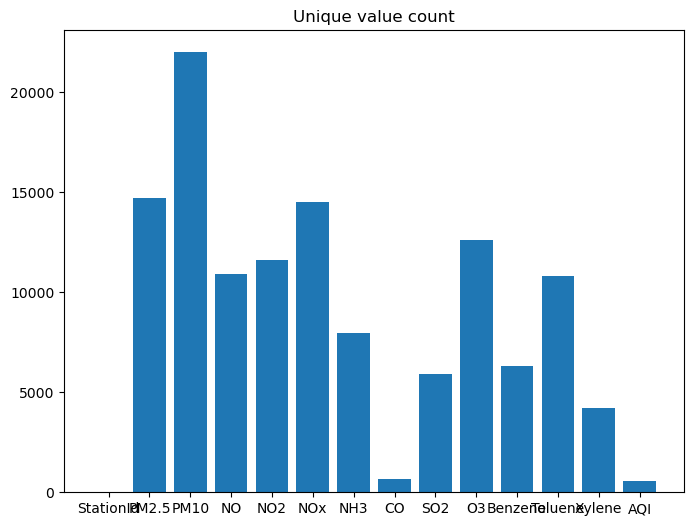

In [13]:
plt.figure(figsize=(8,6))
plt.bar(data.columns,uniq)
plt.title("Unique value count")
plt.show()

In [14]:
le= LabelEncoder()
data['StationId'] = le.fit_transform(data['StationId'])


 StationId 



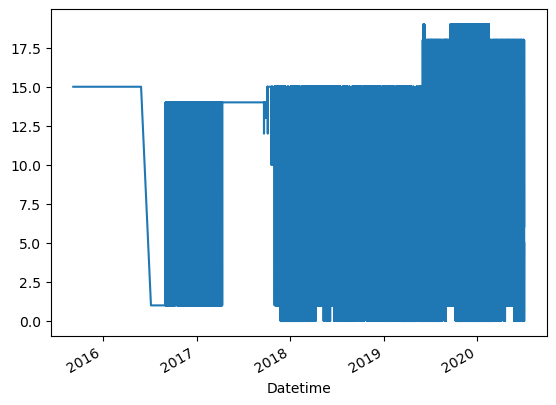


 


 PM2.5 



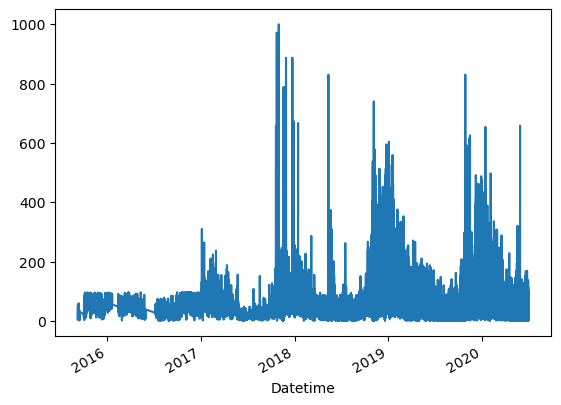


 


 PM10 



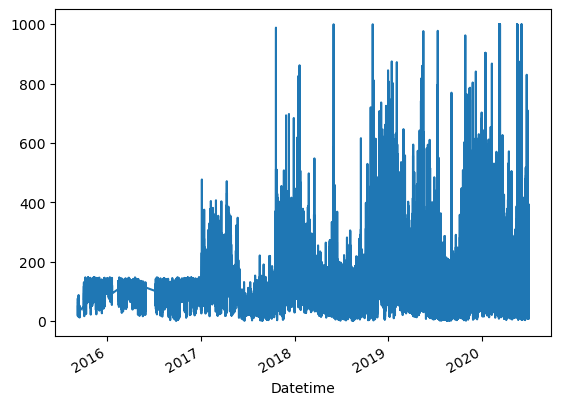


 


 NO 



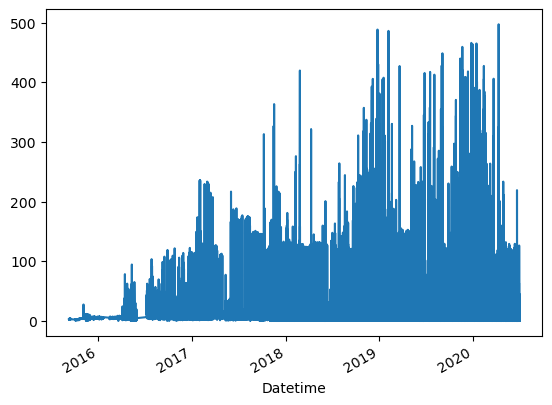


 


 NO2 



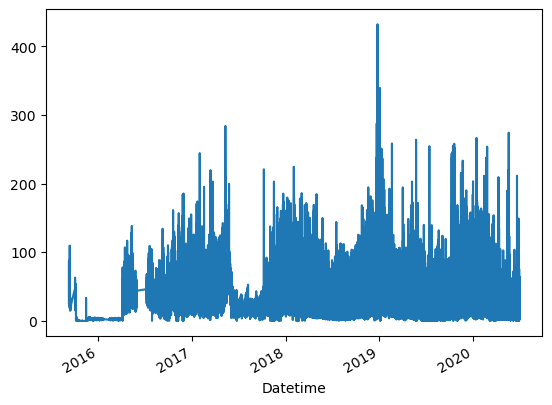


 


 NOx 



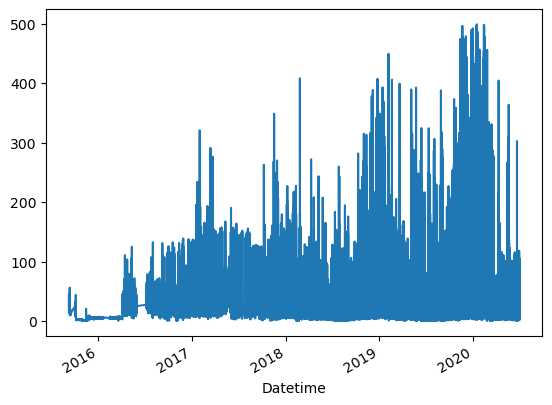


 


 NH3 



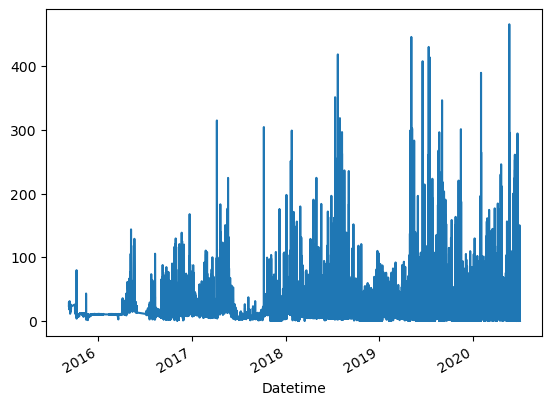


 


 CO 



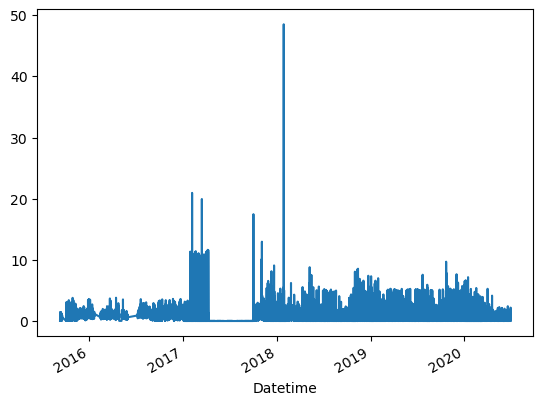


 


 SO2 



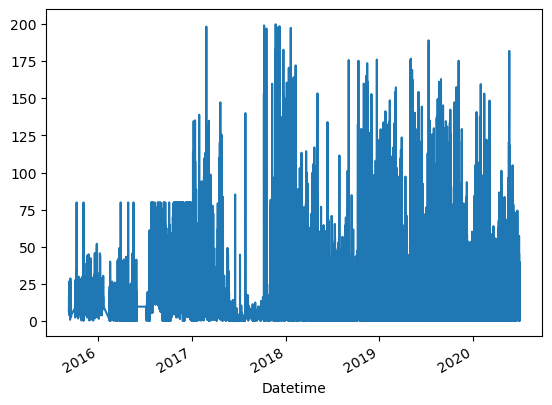


 


 O3 



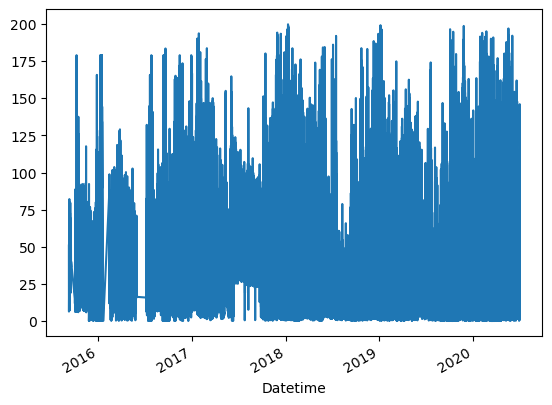


 


 Benzene 



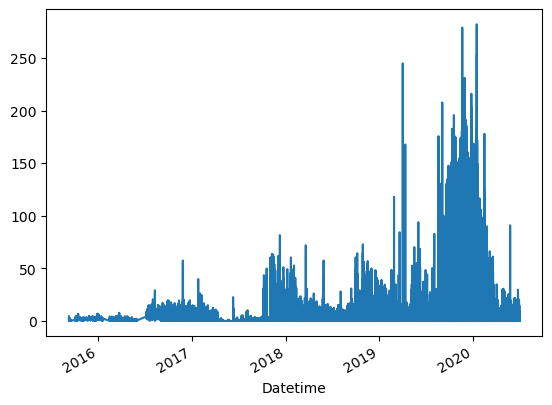


 


 Toluene 



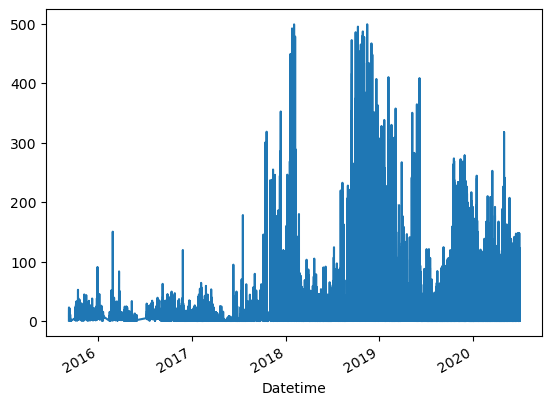


 


 Xylene 



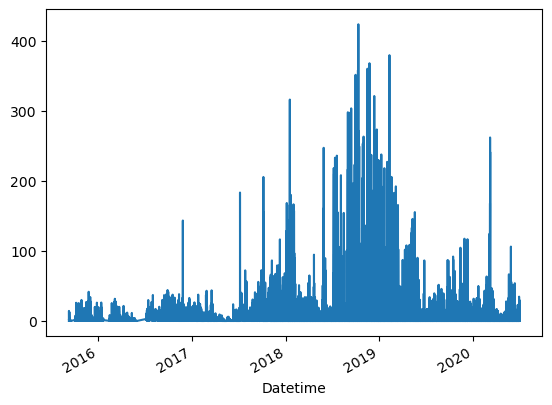


 


 AQI 



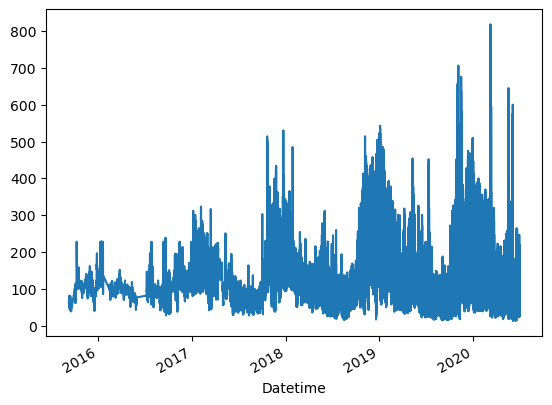

In [15]:
for col in list(data.columns):
    data[col].plot()
    print("\n",col,"\n")
    plt.show()
    print("\n","="*50,"\n \n")

# Data Pre Processing

In [16]:
# Pearson correlation coefficient
corr = data.corr()["AQI"].sort_values(ascending=False)[1:]

# absolute for positive values
abs_corr = abs(corr)

# random threshold for features to keep
relevant_features = abs_corr[abs_corr>0.1]
relevant_features

PM2.5        0.786344
PM10         0.757663
NO2          0.441733
CO           0.432508
NOx          0.426584
NO           0.288469
NH3          0.283593
Toluene      0.169872
SO2          0.135806
Benzene      0.125644
StationId    0.125114
Name: AQI, dtype: float64

In [17]:
dt= data[relevant_features.index]
dt['AQI']= data['AQI']
data= dt

In [18]:
X = data.drop(['AQI'], axis=1)
y = data.AQI
feature_name = X.columns.tolist()

In [19]:
X.shape, y.shape

((203693, 11), (203693,))

In [20]:
Xtrain, Xtest,  y_train, y_test = train_test_split(X, y, test_size= 0.2)
Xtrain.shape, Xtest.shape

((162954, 11), (40739, 11))

# Traditional Models

## Linear Regression

In [21]:
model = LinearRegression(n_jobs=10)
model.fit(Xtrain, y_train)

LinearRegression(n_jobs=10)

In [22]:
y_pred= model.predict(Xtest)

In [23]:
mseLR= mean_squared_error(y_pred,y_test)
rmseLR = np.sqrt(mseLR)
print("Mean Squared Error = ", mseLR)
print("Root Mean Squared Error = ", rmseLR)

Mean Squared Error =  1937.5515569783092
Root Mean Squared Error =  44.01762779817092


## Naive Bayes

In [24]:
model = GaussianNB()

In [25]:
# fit
model.fit(Xtrain, y_train)

GaussianNB()

In [26]:
# predict
y_pred = model.predict(Xtest)

In [27]:
mseNB= mean_squared_error(y_pred,y_test)
rmseNB = np.sqrt(mseNB)
print("Mean Squared Error = ", mseNB)
print("Root Mean Squared Error = ", rmseNB)

Mean Squared Error =  3840.8051744029062
Root Mean Squared Error =  61.97422992182239


# Deep Learning Models

In [28]:
X_train= np.reshape(Xtrain.to_numpy(),(Xtrain.shape[0], 1, Xtrain.shape[1]))
X_test= np.reshape(Xtest.to_numpy(),(Xtest.shape[0], 1, Xtest.shape[1]))
#Shape of the training data
X_train.shape, X_test.shape

((162954, 1, 11), (40739, 1, 11))

# Transformer Model

In [29]:
# Encoder ##################################
input = Input(shape=(1,11))
dense_layer = Dense(11, activation = "relu")(input)
attention_layer = Attention(score_mode="dot")([input, dense_layer])
x = Add()([input , attention_layer]) # residual connection
x = LayerNormalization(epsilon=1e-6)(input)
## Feed Forward
dense = Dense(32, activation='relu')(x)
dense = Dense(1)(dense)
x = Add()([x , dense])     # residual connection
print(x.shape)
encoder = LayerNormalization(epsilon=1e-6)(x)

(None, 1, 11)


In [30]:
# Decoder ##################################
target = Input(shape=(1,11))
## positional encoding
scaling_factor = K.constant(np.sqrt(3), shape = (1,11))
x = Multiply()([target,scaling_factor])
dense_layer = Dense(11, activation = "relu")(target)
attention_layer = Attention(score_mode="dot")([target, dense_layer])
x = Add()([x , attention_layer]) # residual connection
x = LayerNormalization(epsilon=1e-1)(input)
## Feed Forward
dense = Dense(11, activation='relu')(x)
dense = Dense(1)(dense)
x = Add()([x , dense])     # residual connection
print(x.shape)
decoder = LayerNormalization(epsilon=1e-6)(x)

(None, 1, 11)


In [31]:
flatten = Flatten()(decoder)
x = Dense(1, activation='sigmoid')(flatten)
model = Model(inputs=input, outputs=x)
model.summary()
model.compile(loss='poisson', optimizer='sgd', metrics=['mse'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 11)]              0         []                            
                                                                                                  
 layer_normalization_2 (Lay  (None, 1, 11)                22        ['input_1[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 dense_4 (Dense)             (None, 1, 11)                132       ['layer_normalization_2[0][0]'
                                                                    ]                             
                                                                                              

In [32]:
model.fit(X_train,y_train,batch_size=100000,epochs=20)

Epoch 1/20
2/2 [==============================] - 1s 47ms/step - loss: 51.9167 - mse: 20015.5566
Epoch 2/20
2/2 [==============================] - 0s 45ms/step - loss: 1.2407 - mse: 19945.5371
Epoch 3/20
2/2 [==============================] - 0s 45ms/step - loss: 1.2295 - mse: 19945.5215
Epoch 4/20
2/2 [==============================] - 0s 44ms/step - loss: 1.2193 - mse: 19945.5098
Epoch 5/20
2/2 [==============================] - 0s 43ms/step - loss: 1.2097 - mse: 19945.4941
Epoch 6/20
2/2 [==============================] - 0s 44ms/step - loss: 1.2009 - mse: 19945.4805
Epoch 7/20
2/2 [==============================] - 0s 45ms/step - loss: 1.1927 - mse: 19945.4707
Epoch 8/20
2/2 [==============================] - 0s 46ms/step - loss: 1.1850 - mse: 19945.4590
Epoch 9/20
2/2 [==============================] - 0s 44ms/step - loss: 1.1779 - mse: 19945.4492
Epoch 10/20
2/2 [==============================] - 0s 45ms/step - loss: 1.1712 - mse: 19945.4395
Epoch 11/20
2/2 [=====================

In [33]:
loss, mseTrns = model.evaluate(X_test, y_test)
rmseTrns= np.sqrt(mseTrns)
print("Mean Squared Error = ", mseTrns)
print("Root Mean Squared Error = ", rmseTrns)

1274/1274 [==============================] - 2s 2ms/step - loss: 1.1183 - mse: 19766.7383
Mean Squared Error =  19766.73828125
Root Mean Squared Error =  140.59423274533702


### LSTM

In [34]:
#Applying the LSTM model
model = Sequential()
# Configuring the parameters
model.add(LSTM(units=156,activation = 'sigmoid', return_sequences = True, input_shape = (X_train.shape[1],11)))
# Adding a dropout layer
model.add(Dropout(0.2))
# Adding a dense output layer with sigmoid activation
model.add(Dense(units=10))
model.add(Dense(units=1))
# Compiling the model
model.compile(loss='mae', optimizer='sgd', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 156)            104832    
                                                                 
 dropout (Dropout)           (None, 1, 156)            0         
                                                                 
 dense_7 (Dense)             (None, 1, 10)             1570      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              11        
                                                                 
Total params: 106413 (415.68 KB)
Trainable params: 106413 (415.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Training the model
model.fit(X_train,y_train,batch_size=10000,epochs=20)

Epoch 1/20
17/17 [==============================] - 4s 152ms/step - loss: 113.2529 - mse: 18484.6406
Epoch 2/20
17/17 [==============================] - 3s 152ms/step - loss: 73.2223 - mse: 10677.4316
Epoch 3/20
17/17 [==============================] - 3s 154ms/step - loss: 45.1206 - mse: 5456.3013
Epoch 4/20
17/17 [==============================] - 3s 154ms/step - loss: 43.7905 - mse: 5030.1006
Epoch 5/20
17/17 [==============================] - 3s 173ms/step - loss: 42.8832 - mse: 4861.1807
Epoch 6/20
17/17 [==============================] - 3s 157ms/step - loss: 42.6691 - mse: 4750.6851
Epoch 7/20
17/17 [==============================] - 3s 160ms/step - loss: 41.1235 - mse: 4620.0103
Epoch 8/20
17/17 [==============================] - 3s 160ms/step - loss: 40.7953 - mse: 4511.7549
Epoch 9/20
17/17 [==============================] - 3s 159ms/step - loss: 40.3702 - mse: 4404.7632
Epoch 10/20
17/17 [==============================] - 3s 159ms/step - loss: 39.7286 - mse: 4281.9087
Epoch 

In [36]:
loss, mseLSTM= model.evaluate(X_test, y_test)

1274/1274 [==============================] - 3s 2ms/step - loss: 38.0320 - mse: 3997.2520


In [37]:
rmseLSTM= np.sqrt(mseLSTM)
print("Mean Squared Error = ", mseLSTM)
print("Root Mean Squared Error = ", rmseLSTM)

Mean Squared Error =  3997.251953125
Root Mean Squared Error =  63.22382425261066


# Graph NN

In [38]:
hidden_units = [64, 32]
learning_rate = 0.1
dropout_rate = 0.01

In [39]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []
    for units in hidden_units:        
        fnn_layers.append(BatchNormalization())
        fnn_layers.append(Dropout(dropout_rate))
        fnn_layers.append(Dense(units, activation='relu'))
    return Sequential(fnn_layers, name=name)

In [40]:
def createGNN(hidden_units, num_classes, dropout_rate):
    inputs = Input(shape=(1,11), name="input_features")
    X=LSTM(units=128,activation = 'sigmoid', return_sequences = True)(inputs)
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(X)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    x= Flatten()(x)
    logits = Dense(2, name="logits")(x)
    # Create the model.
    return Model(inputs=inputs, outputs=logits, name="GraphCNN")


model = createGNN(hidden_units, 1, dropout_rate)
model.summary()
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

Model: "GraphCNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 1, 11)]              0         []                            
 )                                                                                                
                                                                                                  
 lstm_1 (LSTM)               (None, 1, 128)               71680     ['input_features[0][0]']      
                                                                                                  
 ffn_block1 (Sequential)     (None, 1, 32)                11104     ['lstm_1[0][0]']              
                                                                                                  
 ffn_block2 (Sequential)     (None, 1, 32)                4576      ['ffn_block1[0][0]']   

In [41]:
# Training the model
model.fit(X_train,y_train,batch_size=5000,epochs=20)

Epoch 1/20
33/33 [==============================] - 12s 142ms/step - loss: 115.5618 - mse: 19060.1445
Epoch 2/20
33/33 [==============================] - 5s 146ms/step - loss: 95.1702 - mse: 14768.6348
Epoch 3/20
33/33 [==============================] - 6s 169ms/step - loss: 59.1915 - mse: 8181.6582
Epoch 4/20
33/33 [==============================] - 6s 167ms/step - loss: 35.0334 - mse: 3591.4563
Epoch 5/20
33/33 [==============================] - 5s 157ms/step - loss: 27.9102 - mse: 2005.0172
Epoch 6/20
33/33 [==============================] - 6s 180ms/step - loss: 26.0861 - mse: 1688.8787
Epoch 7/20
33/33 [==============================] - 5s 159ms/step - loss: 25.4881 - mse: 1614.9453
Epoch 8/20
33/33 [==============================] - 5s 154ms/step - loss: 25.2857 - mse: 1590.2372
Epoch 9/20
33/33 [==============================] - 5s 146ms/step - loss: 25.0036 - mse: 1564.1555
Epoch 10/20
33/33 [==============================] - 5s 147ms/step - loss: 24.8518 - mse: 1541.8284
Epoch

In [42]:
loss, mseGNN = model.evaluate(X_test, y_test)

1274/1274 [==============================] - 5s 3ms/step - loss: 24.8691 - mse: 1601.8639


In [43]:
rmseGNN= np.sqrt(mseGNN)
print("Mean Squared Error = ", mseGNN)
print("Root Mean Squared Error = ", rmseGNN)

Mean Squared Error =  1601.8638916015625
Root Mean Squared Error =  40.02329186363314


# Hybrid Model

In [44]:
def createHybridModel(hidden_units, num_classes, dropout_rate):
    inputs = Input(shape=(1,11), name="input_features")
    X=LSTM(units=11,activation = 'sigmoid', return_sequences = True)(inputs)
    attention_layer = Attention(score_mode="dot")([inputs, X])
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(attention_layer)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    x= Flatten()(x)
    logits = Dense(1, name="logits")(x)
    # Create the model.
    return Model(inputs=inputs, outputs=logits, name="GraphCNN")

model = createHybridModel(hidden_units, 1, dropout_rate)
model.summary()
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

Model: "GraphCNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 1, 11)]              0         []                            
 )                                                                                                
                                                                                                  
 lstm_2 (LSTM)               (None, 1, 11)                1012      ['input_features[0][0]']      
                                                                                                  
 attention_2 (Attention)     (None, 1, 11)                0         ['input_features[0][0]',      
                                                                     'lstm_2[0][0]']              
                                                                                           

In [45]:
# Training the model
model.fit(X_train,y_train,batch_size=5000,epochs=20)

Epoch 1/20
33/33 [==============================] - 15s 76ms/step - loss: 113.7842 - mse: 18611.6621
Epoch 2/20
33/33 [==============================] - 3s 76ms/step - loss: 94.4137 - mse: 14559.7646
Epoch 3/20
33/33 [==============================] - 3s 83ms/step - loss: 64.5383 - mse: 9088.3818
Epoch 4/20
33/33 [==============================] - 3s 76ms/step - loss: 44.0179 - mse: 5284.3271
Epoch 5/20
33/33 [==============================] - 2s 76ms/step - loss: 39.9597 - mse: 4341.7324
Epoch 6/20
33/33 [==============================] - 3s 76ms/step - loss: 36.7883 - mse: 3655.1692
Epoch 7/20
33/33 [==============================] - 3s 77ms/step - loss: 31.7532 - mse: 2581.4331
Epoch 8/20
33/33 [==============================] - 3s 78ms/step - loss: 28.5000 - mse: 1964.7733
Epoch 9/20
33/33 [==============================] - 3s 79ms/step - loss: 27.7958 - mse: 1868.4474
Epoch 10/20
33/33 [==============================] - 3s 78ms/step - loss: 27.3168 - mse: 1814.1487
Epoch 11/20
33/

In [46]:
loss, mseHyb = model.evaluate(X_test, y_test)

1274/1274 [==============================] - 4s 2ms/step - loss: 28.0405 - mse: 2057.5281


In [47]:
rmseHYb= np.sqrt(mseHyb)
print("Mean Squared Error = ", mseHyb)
print("Root Mean Squared Error = ", rmseHYb)

Mean Squared Error =  2057.528076171875
Root Mean Squared Error =  45.35998320294966


# Performance Evaluation

In [49]:
performancves= pd.DataFrame({"Models": ['Linear Regression', 'Naive Bayes', 'Transformer Model', 'LSTM', 'GNN', 'Hybrid Model'],
                            "Mean Squared Error": [mseLR, mseNB, mseTrns, mseLSTM, mseGNN,mseHyb],
                            "Root Mean Squared Error": [rmseLR, rmseNB, rmseTrns, rmseLSTM, rmseGNN, rmseHYb]})

In [50]:
performancves.sort_values(by='Root Mean Squared Error')

,Models,Mean Squared Error,Root Mean Squared Error
4,GNN,1601.863892,40.023292
0,Linear Regression,1937.551557,44.017628
5,Hybrid Model,2057.528076,45.359983
1,Naive Bayes,3840.805174,61.974230
3,LSTM,3997.251953,63.223824
2,Transformer Model,19766.738281,140.594233


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Naive Bayes'),
  Text(2, 0, 'Transformer Model'),
  Text(3, 0, 'LSTM'),
  Text(4, 0, 'GNN'),
  Text(5, 0, 'Hybrid Model')])

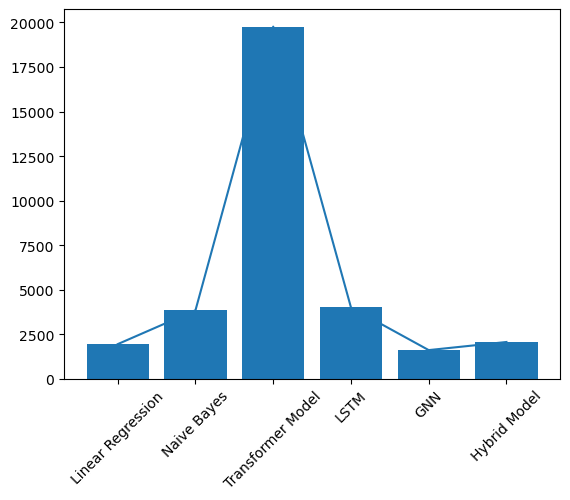

In [53]:
plt.plot(performancves['Models'], performancves['Mean Squared Error'])
plt.bar(performancves['Models'], performancves['Mean Squared Error'])
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Naive Bayes'),
  Text(2, 0, 'Transformer Model'),
  Text(3, 0, 'LSTM'),
  Text(4, 0, 'GNN'),
  Text(5, 0, 'Hybrid Model')])

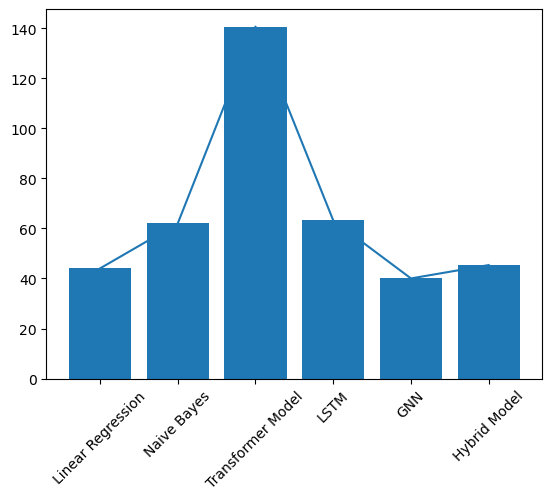

In [54]:
plt.plot(performancves['Models'], performancves['Root Mean Squared Error'])
plt.bar(performancves['Models'], performancves['Root Mean Squared Error'])
plt.xticks(rotation=45)